原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.1'

# Deep Dream

This notebook contains the code samples found in Chapter 8, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

[...]

## Implementing Deep Dream in Keras


We will start from a convnet pre-trained on ImageNet. In Keras, we have many such convnets available: VGG16, VGG19, Xception, ResNet50... 
albeit the same process is doable with any of these, your convnet of choice will naturally affect your visualizations, since different 
convnet architectures result in different learned features. The convnet used in the original Deep Dream release was an Inception model, and 
in practice Inception is known to produce very nice-looking Deep Dreams, so we will use the InceptionV3 model that comes with Keras.

## 用 Keras 实现 DeepDream

我们将从一个在 ImageNet 上预训练的卷积神经网络开始。Keras 中有许多这样的卷积神经 网络：VGG16、VGG19、Xception、ResNet50 等。我们可以用其中任何一个来实现 DeepDream，但我们选择的卷积神经网络会影响可视化的效果，因为不同的卷积神经网络架构会学到不同的特征。最初发布的 DeepDream 中使用的卷积神经网络是一个 Inception 模型，在实践中，人们已经知道 Inception 能够生成漂亮的 DeepDream 图像，所以我们将使用 Keras 内置的 Inception V3 模型。



In [2]:
from keras.applications import inception_v3
from keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
# 我们不需要训练模型，所以这个命令会禁用所有与训练有关的操作
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
# 构建不包括全连接层的 Inception V3 网络。使用预训练的 ImageNet 权重来加载模型
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)


Next, we compute the "loss", the quantity that we will seek to maximize during the gradient ascent process. In Chapter 5, for filter 
visualization, we were trying to maximize the value of a specific filter in a specific layer. Here we will simultaneously maximize the 
activation of all filters in a number of layers. Specifically, we will maximize a weighted sum of the L2 norm of the activations of a 
set of high-level layers. The exact set of layers we pick (as well as their contribution to the final loss) has a large influence on the 
visuals that we will be able to produce, so we want to make these parameters easily configurable. Lower layers result in 
geometric patterns, while higher layers result in visuals in which you can recognize some classes from ImageNet (e.g. birds or dogs).
We'll start from a somewhat arbitrary configuration involving four layers -- 
but you will definitely want to explore many different configurations later on:

接下来，我们要计算损失（loss），即在梯度上升过程中需要最大化的量。在第 5 章的过滤器可视化中，我们试图将某一层的某个过滤器的值最大化。这里，我们要将多个层的所有过滤器的激活同时最大化。具体来说，就是对一组靠近顶部的层激活的 L2 范数进行加权求和，然后将其最大化。选择哪些层（以及它们对最终损失的贡献）对生成的可视化结果具有很大影响， 所以我们希望让这些参数变得易于配置。更靠近底部的层生成的是几何图案，而更靠近顶部的层生成的则是从中能够看出某些 ImageNet 类别（比如鸟或狗）的图案。我们将随意选择 4 层的配置，但你以后一定要探索多个不同的配置。


In [3]:
# Dict mapping layer names to a coefficient
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
# 这个字典将层的名称映射为一个系数，这个系数定量表示该层激活对你要最大化的损失的贡献大小。
# 注意，层的名称硬编码在内置的 Inception V3 应用中。可以使用 model.summary() 列出所有层的名称

layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

Now let's define a tensor that contains our loss, i.e. the weighted sum of the L2 norm of the activations of the layers listed above.

接下来，我们来定义一个包含损失的张量，损失就是代码清单 8-9 中层激活的 L2 范数的加权求和。


In [4]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
# 创建一个字典，将层的名称映射为层的实例
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
# 在定义损失时将层的贡献添加到这个标量变量中
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    #将该层特征的 L2 范数添加到 loss中。
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    #为了避免出现边界伪影，损失中仅包 含非边界的像素
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

Now we can set up the gradient ascent process:

下面来设置梯度上升过程。

In [5]:
# This holds our generated image（这个张量用于保存生成的图像，即梦境图像）
dream = model.input

# Compute the gradients of the dream with regard to the loss.
# 计算损失相对于梦境图像的梯度
grads = K.gradients(loss, dream)[0]

# Normalize gradients.（将梯度标准化（重要技巧））
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
# 给定一张输出图像，设置 一个 Keras 函数来获取损失值和梯度值
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x
# 这个函数运行 iterations次梯度上升



Finally, here is the actual Deep Dream algorithm.

First, we define a list of "scales" (also called "octaves") at which we will process the images. Each successive scale is larger than 
previous one by a factor 1.4 (i.e. 40% larger): we start by processing a small image and we increasingly upscale it:

最后就是实际的 DeepDream 算法。

首先，我们来定义一个列表，里面包含的是处理图像的 尺度（也叫八度）。每个连续的尺度都是前一个的 1.4 倍（放大 40%），即首先处理小图像，然后逐渐增大图像尺寸（见下图）。

![deep dream process](data/deepdream_process.png)


Then, for each successive scale, from the smallest to the largest, we run gradient ascent to maximize the loss we have previously defined, 
at that scale. After each gradient ascent run, we upscale the resulting image by 40%.

To avoid losing a lot of image detail after each successive upscaling (resulting in increasingly blurry or pixelated images), we leverage a 
simple trick: after each upscaling, we reinject the lost details back into the image, which is possible since we know what the original 
image should look like at the larger scale. Given a small image S and a larger image size L, we can compute the difference between the 
original image (assumed larger than L) resized to size L and the original resized to size S -- this difference quantifies the details lost 
when going from S to L.

对于每个连续的尺度，从最小到最大，我们都需要在当前尺度运行梯度上升，以便将之前定义的损失最大化。每次运行完梯度上升之后，将得到的图像放大 40%。

在每次连续的放大之后（图像会变得模糊或像素化），为避免丢失大量图像细节，我们可以使用一个简单的技巧：每次放大之后，将丢失的细节重新注入到图像中。这种方法是可行的，因为我们知道原始图像放大到这个尺寸应该是什么样子。给定一个较小的图像尺寸 S 和一个较大的图像尺寸 L，你可以计算将原始图像大小调整为 L 与将原始图像大小调整为 S 之间的区别，这个区别可以定量描述从 S 到 L 的细节损失。


The code above below leverages the following straightforward auxiliary Numpy functions, which all do just as their name suggests. They 
require to have SciPy installed.

注意，上述代码使用了下面这些简单的 Numpy 辅助函数，其功能从名称中就可以看出来。它们都需要安装 SciPy。


In [6]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    #通用函数，用于打开图像、改变图像大小以及将图像格式转换为 Inception V3 模型能够处理的张量     
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    #通用函数，将一个张量转换为有效图像
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects
# 改变这些超参数，可以得到新的效果

step = 0.01  # Gradient ascent step size（梯度上升的步长）
num_octave = 3  # Number of scales at which to run gradient ascent（运行梯度上升的尺度个数）
octave_scale = 1.4  # Size ratio between scales（两个尺度之间的大小比例）
iterations = 20  # Number of ascent steps per scale（在每个尺度上运行梯度上升的步数）

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
# 如果损失增大到大于 10，我们要中断梯度上升过程，以避免得到丑陋的伪影 
max_loss = 10.

# Fill this to the path to the image you want to use
# 将基础图像加载成一个 Numpy 数组
base_image_path = 'data/original_photo_deep_dream.jpg'

# Load the image into a Numpy array
# 将基础图像加载成一个 Numpy 数组
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
# 准备一个由形状元组组成的列表，它定义了运行梯度上升的不同尺度
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
# 将形状列表反转，变为升序
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
# 将图像 Numpy 数组的大小缩放到最小尺寸
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (178, 178)
...Loss value at 0 : 0.671784
...Loss value at 1 : 1.08264
...Loss value at 2 : 1.54393
...Loss value at 3 : 2.06223
...Loss value at 4 : 2.59245
...Loss value at 5 : 3.16763
...Loss value at 6 : 3.74595
...Loss value at 7 : 4.28417
...Loss value at 8 : 4.88212
...Loss value at 9 : 5.40915
...Loss value at 10 : 5.93532
...Loss value at 11 : 6.38805
...Loss value at 12 : 6.96173
...Loss value at 13 : 7.46732
...Loss value at 14 : 7.98175
...Loss value at 15 : 8.3428
...Loss value at 16 : 8.86652
...Loss value at 17 : 9.27951
...Loss value at 18 : 9.65843


c:\programdata\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


Processing image shape (250, 250)
...Loss value at 0 : 2.17149
...Loss value at 1 : 3.43533
...Loss value at 2 : 4.48454
...Loss value at 3 : 5.29698
...Loss value at 4 : 6.17493
...Loss value at 5 : 6.97546
...Loss value at 6 : 7.66492
...Loss value at 7 : 8.36713
...Loss value at 8 : 8.9605
...Loss value at 9 : 9.62507
Processing image shape (350, 350)
...Loss value at 0 : 2.28274
...Loss value at 1 : 3.43982
...Loss value at 2 : 4.48018
...Loss value at 3 : 5.45595
...Loss value at 4 : 6.38898
...Loss value at 5 : 7.38413
...Loss value at 6 : 8.51768
...Loss value at 7 : 9.81511


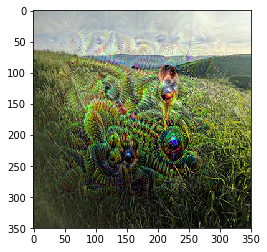

In [9]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

注意：因为原始 Inception V3 网络训练识别尺寸为 299×299 的图像中的概念，而上述过程中将图像尺寸减小很多，所以 DeepDream 实现在尺寸介于 300×300 和 400×400 之间的图像上能够得到更好的结果。但不管怎样，你都可以在任何尺寸和任何比例的图像上运行同样的代码。
